In [35]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns
import matplotlib.image as mpimg 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import plot_confusion_matrix, recall_score
from sklearn.metrics import accuracy_score, log_loss, precision_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import copy

%matplotlib inline

In [2]:
# Quick import of cleaned/imputed data
complete_df = pd.read_csv('data/RF_imputed_df.csv')

In [3]:
# One hot encode the specified columns, remove the original columns, append the 
# encoded columns, and return df

def create_ohe_df(df, col_list):
    df2 = copy.copy(df)
    
    temp_df = df[col_list] 
    df2 = df2.drop(columns=col_list)
    
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(temp_df)
    one_hot_df = enc.transform(temp_df)
    
    return pd.concat([df2, pd.DataFrame(one_hot_df.todense())], axis=1)


In [4]:
OHE_df = create_ohe_df(complete_df, ['Ethnicity', 'Gender', 'Been_Arrested', 
                                         'State', 'Work_Situation'])

In [ ]:
s1_df.groupby('Religious_Life')['Religious_Life'].count()

In [ ]:
s1_df = create_ohe_df(redo_df, ['Ethnicity', 'Gender', 'Been_Arrested', 
                                         'State', 'Work_Situation'])

In [ ]:
s1_df = s1_df.drop(columns=['Dataset', 'Current_Drinker'])

In [ ]:
RLife_mask = s1_df['Religious_Life'].between(1,4)
s2_RLife = s1_df[RLife_mask]
RLife_missing = s1_df[~RLife_mask].drop(columns=['Religious_Life'])

Alc_mask = s1_df['Importance_Alcoholic'].between(1,4)
s2_Alc = s1_df[Alc_mask]
Alc_missing = s1_df[~Alc_mask].drop(columns=['Importance_Alcoholic'])

FF_mask = s1_df['Importance_Friends_Family'].between(1,4)
s2_FF = s1_df[FF_mask]
FF_missing = s1_df[~FF_mask].drop(columns=['Importance_Friends_Family'])

Rel_mask = s1_df['Importance_Religion'].between(1,4)
s2_RL = s1_df[Rel_mask]
Rel_missing = s1_df[~Rel_mask].drop(columns=['Importance_Religion'])

In [ ]:
X1_train, X1_test, y1_train, y1_test= convert_split(s2_RL, 'Importance_Religion')
X2_train, X2_test, y2_train, y2_test= convert_split(s2_Alc, 'Importance_Alcoholic')
X3_train, X3_test, y3_train, y3_test= convert_split(s2_FF, 'Importance_Friends_Family')
X4_train, X4_test, y4_train, y4_test= convert_split(s2_RLife, 'Religious_Life')

In [ ]:
I_Rel_model = create_RF(X1_train, X1_test, y1_train, y1_test,
                        class_weight={1:1,2:2,3:2,4:1})

In [ ]:
I_Alc_model = create_RF(X2_train, X2_test, y2_train, y2_test,
                       class_weight={1:1.5,2:2,3:2,4:1})

In [ ]:
I_FF_model = create_RF(X3_train, X3_test, y3_train, y3_test, 
                       class_weight={1:1,2:1.5,3:1.5,4:1})

In [ ]:
I_RLife_model = create_RF(X4_train, X4_test, y4_train, y4_test, 
                          class_weight={1:.2,2:.8,3:2.2,4:3.5})

In [ ]:
Pred_Alc = I_Alc_model.predict(Alc_missing)
Pred_FF = I_FF_model.predict(FF_missing)
Pred_ReL = I_Rel_model.predict(Rel_missing)
Pred_RLife = I_RLife_model.predict(RLife_missing)

In [ ]:
Rel_missing['Importance_Religion'] = Pred_ReL
FF_missing['Importance_Friends_Family'] = Pred_FF
Alc_missing['Importance_Alcoholic'] = Pred_Alc
RLife_missing['Religious_Life'] = Pred_RLife

In [ ]:
RL_final = pd.concat([s2_RL, Rel_missing], axis=0)
RLife_final = pd.concat([s2_RLife, RLife_missing], axis=0)
FF_final = pd.concat([s2_FF, FF_missing], axis=0)
Alc_final = pd.concat([s2_Alc, Alc_missing], axis=0)

In [ ]:
RF_imputed_df = redo_df.drop(columns = ['Importance_Alcoholic',
                                        'Importance_Religion',
                                        'Importance_Friends_Family', 
                                        'Religious_Life'])
RF_imputed_df['Importance_Alcoholic'] = Alc_final['Importance_Alcoholic']
RF_imputed_df['Importance_Religion'] = RL_final['Importance_Religion']
RF_imputed_df['Importance_Friends_Family'] = FF_final['Importance_Friends_Family']
RF_imputed_df['Religious_Life'] = RLife_final['Religious_Life']

In [ ]:
RF_imputed_df.to_csv('data/RF_imputed_df.csv')

In [ ]:
def create_RF(X_train, X_test, y_train, y_test, class_weight={1:1, 2:1, 3:1, 4:1}):
    RF_model = RandomForestClassifier(max_depth=10, n_estimators=600, 
                                      min_samples_split=6, min_samples_leaf=4,
                                     class_weight=class_weight)
    RF_model.fit(X_train, y_train)

    #RF_train_predict = RF_model.predict(X_train)
    #RF_train_proba = RF_model.predict_proba(X_train)
    #RF_test_predict = RF_model.predict(X_test)

    #print(f'Acc: {accuracy_score(y_test, RF_test_predict)}')
    #print(f'Loss: {log_loss(y_train, RF_train_proba)}')
    #RF_conf = plot_confusion_matrix(RF_model, X_test ,y_test ,normalize='true',cmap='YlOrRd')
    #RF_conf.ax_.grid(False)
    #RF_conf.ax_.set_title('RF');
    
    return RF_model

In [10]:
cluster_df = copy.copy(OHE_df.drop(columns=['Dataset', 'Current_Drinker', 'Unnamed: 0']))

In [11]:
# add target feature according to Average Drinking feature

cluster_df['target'] = cluster_df['Average_Drinking'].map(lambda x: 0 if x==11
                                                                      else 1 if x==7 or x==8
                                                                      else 2 if x<=5
                                                                         else None)

# filter df by values in Average Drinking which belong to a label
train_df = cluster_df[cluster_df['target'].notnull()]
train_df = train_df.drop(columns=['Beer_Frequency', 'Liquor_Frequency', 'Wine_Frequency', 
                                  'Average_Drinking']);

In [12]:
# Function to balance all labels equally depending on the size of the minority.
# Percent argument determines the sample size by increasing the minority size by the 
# specified percentage. All labels under this threshold are oversampled, and all 
# labels over the threshold are undersampled.

def balance_classes(train_df, percent):
    
    zeros = train_df[train_df['target'] == 0]
    ones = train_df[train_df['target'] == 1]
    twos = train_df[train_df['target'] == 2]

    # Make list of labels which have more than 0 data points
    label_list = [ones, twos, zeros]
    non_zero_labels = []
    for label in label_list:
        if label.shape[0] != 0:
            non_zero_labels.append(label)
        
    # get list of sized of labels to find the minority
    labels = []
    for label in non_zero_labels:
        labels.append(label.shape[0])
    
    minority = np.min(labels)
    total_rows = twos.shape[0]+ones.shape[0]+zeros.shape[0]
    
    # Calculate the target number of data points for each class
    target_num = int(total_rows * ((minority/total_rows) + (minority/total_rows) * percent)) 
    
    # resample all labels accoprding to the target sample size
    resampled_zeros = resample(zeros, n_samples=target_num, stratify=zeros)
    resampled_ones = resample(ones, n_samples=target_num, stratify=ones)
    resampled_twos = resample(twos, n_samples=target_num, stratify=twos)
    
    # create new dataframe containing all resampled labels
    train_df = pd.concat([resampled_zeros, resampled_twos, resampled_ones],  
                         ignore_index=True)
    
    
    return train_df 

In [13]:
train_df = balance_classes(train_df, .35)

In [14]:
# Create X and y for train_test_split

def convert_split(df, target_col):    

    X = df.drop(columns=target_col)
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test= convert_split(train_df, 'target')

In [22]:
# Create GB model, print the accuracy,log loss and confusion matrix

def create_GB_model(rate):
    #GB_model = GradientBoostingClassifier(learning_rate=0.03, max_depth=10, n_estimators=600, 
    #                                  min_samples_split=8, min_samples_leaf=2)
    GB_model = GradientBoostingClassifier(learning_rate=rate)
    GB_model.fit(X_train, y_train)

    GB_train_predict = GB_model.predict(X_train)
    GB_train_proba = GB_model.predict_proba(X_train)
    GB_test_predict = GB_model.predict(X_test)
    
    print(f'Acc: {accuracy_score(y_test, GB_test_predict)}')
    print(f'Loss: {log_loss(y_train, GB_train_proba)}')
    '''
    GB_conf = plot_confusion_matrix(GB_model, X_test ,y_test ,normalize='true', cmap=plt.cm.Blues)
    GB_conf.ax_.grid(False)
    GB_conf.ax_.set_title('GB Unbalanced Classes');
    '''
    
    acc = accuracy_score(y_test, GB_test_predict)
    loss = log_loss(y_train, GB_train_proba)
    list1 = [acc,loss]
    return list1

In [ ]:
# Create RF model, print the accuracy,log loss and confusion matrix

def create_RF_model(max_depth=10, n_estimators=600, min_samples_split=6, 
                    min_samples_leaf=4):
    RF_model = RandomForestClassifier(max_depth = max_depth, 
                                      n_estimators = n_estimators, 
                                      min_samples_split = min_samples_split, 
                                      min_samples_leaf = min_samples_leaf,
                                     warm_start=True)
    RF_model.fit(X_train, y_train)

    RF_train_predict = RF_model.predict(X_train)
    RF_train_proba = RF_model.predict_proba(X_train)
    RF_test_predict = RF_model.predict(X_test)

    print(f'Acc: {accuracy_score(y_test, RF_test_predict)}')
    print(f'Loss: {log_loss(y_train, RF_train_proba)}')
    print(f'Max Depth: {max_depth}\nn_esitmators: {n_estimators}\nmin_saples_split: {min_samples_split}\nmin_samples_leaf: {min_samples_leaf}')
    '''
    RF_conf = plot_confusion_matrix(RF_model, X_test ,y_test ,normalize='true',cmap=plt.cm.Blues)
    RF_conf.ax_.grid(False)
    RF_conf.ax_.set_title('RF Balanced Classes');
    '''
    return RF_model


In [82]:
def create_LR_model():
    LR_model = LogisticRegression(max_iter=1700)
    
    LR_model.fit(X_train, y_train)
    
    LR_train_predict = LR_model.predict(X_train)
    LR_train_proba = LR_model.predict_proba(X_train)
    LR_test_predict = LR_model.predict(X_test)
    
    print(f'Acc: {accuracy_score(y_test, LR_test_predict)}')
    print(f'Loss: {log_loss(y_train, LR_train_proba)}')
    '''
    LR_conf = plot_confusion_matrix(LR_model, X_test ,y_test ,normalize='true',cmap=plt.cm.Blues)
    LR_conf.ax_.grid(False)
    LR_conf.ax_.set_title('LR Unbalanced Classes', fontsize=16)
    LR_conf.ax_.set_xlabel('Predicted Label', fontsize=14)
    LR_conf.ax_.set_ylabel('True Label',fontsize=14);
    #LR_conf.ax_.text(fontsize=14)
    '''
    return LR_model

In [79]:
sns.set(font_scale=1.2)

In [80]:
def make_confusion_matrix(model):
    
    _ = plot_confusion_matrix(model, X_test ,y_test ,normalize='true', cmap='Blues')
    _.ax_.grid(False)
    _.ax_.set_title('Unbalanced Classes', fontsize=18)
    _.ax_.set_xlabel('Predicted Label', fontsize=16)
    _.ax_.set_ylabel('True Label',fontsize=16);
    plt.tight_layout()
    plt.savefig('Unbalanced_LR.png', format='png')
    return plt

In [26]:
rates = [.002,.005,.008,.1,.2,.3]
rates2 = [.3,.4,.5,.6,.7,.8]

In [29]:
rates = rates[::-1]

In [31]:
for rate in rates:
    list1.insert(0, create_GB_model(rate))
    
test_list.insert(0, 6) 

Acc: 0.5882993197278912
Loss: 0.758162395087851
Acc: 0.5842176870748299
Loss: 0.7869116144130452
Acc: 0.5836734693877551
Loss: 0.8224621643873535
Acc: 0.5570068027210885
Loss: 0.9682574723221162
Acc: 0.5586394557823129
Loss: 1.0000976963613355
Acc: 0.5580952380952381
Loss: 1.0489532687580316


NameError: name 'test_list' is not defined

In [28]:
list1

[[0.5880272108843537, 0.758162395087851],
 [0.5831292517006803, 0.7312577373450739],
 [0.582312925170068, 0.7076621426335763],
 [0.5831292517006803, 0.6914441662435024],
 [0.5853061224489796, 0.6733266246209988],
 [0.5798639455782313, 0.6608722912637015]]

In [ ]:
learning_rate_df = np.asarray(list1)

In [83]:
un_LR = create_LR_model()

Acc: 0.8049281314168378
Loss: 0.42649252950201716


In [55]:
oob_GB3 = create_GB_model()

Acc: 0.5882993197278912
Loss: 0.8200501558401401


<module 'matplotlib.pyplot' from '/media/illuminator/Main/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

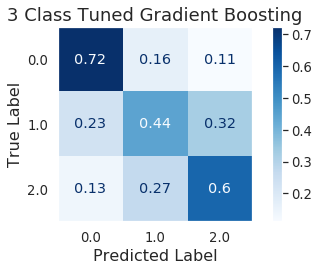

In [72]:
make_confusion_matrix(oob_GB3)

In [69]:
GB3 = create_GB_model()

Acc: 0.6247619047619047
Loss: 0.16114837437419846


<module 'matplotlib.pyplot' from '/media/illuminator/Main/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

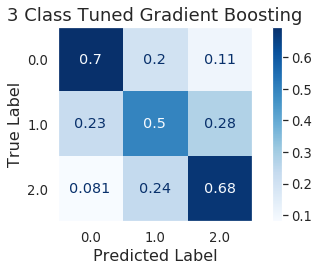

In [73]:
make_confusion_matrix(GB3)

In [ ]:
pred_proba_df = pd.DataFrame(RF_model.predict_proba(X_test))
#threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
threshold_list = [0.5,.51,.52,.53,.54,.55]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                                           Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1))
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                           Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1)))

In [ ]:
# max_depth=20, n_estimators=800, min_samples_split=10, min_samples_leaf=4
#
create_RF_model()

In [ ]:
# max_depth=10, n_estimators=600, min_samples_split=6, min_samples_leaf=4
#
create_RF_model()

In [ ]:
# learning_rate=0.03, max_depth=4, n_estimators=800, 
# min_samples_split=10, min_samples_leaf=4
create_GB_model()

In [ ]:
# learning_rate=0.08, max_depth=12, n_estimators=1200, 
# min_samples_split=10, min_samples_leaf=4
create_GB_model()

In [ ]:
create_GB_model()

In [ ]:
list1 = [4,8]
score_list=[]
for value in list1:
    score_list.append(create_RF_model(min_samples_split=value))

In [ ]:
plot_df4 = pd.DataFrame(score_list, columns=['min_samples_split', 'Acc', 'Loss']).set_index('min_samples_split')

In [ ]:
score_list

In [ ]:
# Gradient Boosting
# 2 classes balanced

print(f'Accuracy: {accuracy_score(y_test, GB_test_predict)}')
print(f'Log Loss:: {log_loss(y_train, GB_train_proba)}')

GB_conf = plot_confusion_matrix(GB_model, X_train ,y_train ,normalize='true',cmap='YlOrRd')
GB_conf.ax_.grid(False)
GB_conf.ax_.set_title('Gradient Boosting 2 Balanced Classes');

In [ ]:
def gradient_class_grid_search():
    
    params = {
        'learning_rate':[.005,.008],
        'n_estimators':[800,1000,1200],
        'min_samples_split':[6,9],
        'min_samples_leaf':[2,4],
        'max_depth':[15, 20],
        'warm_start':[False]}
        
    gg_gridsearch = GridSearchCV(GradientBoostingClassifier(), 
                  params,
                  n_jobs=-1,
                  verbose=True,
                  scoring='neg_log_loss',
                  cv=1)

    gg_gridsearch.fit(X_train, y_train)
    
    print(gg_gridsearch.best_params_)
    return gg_gridsearch.best_params_


best_accuracy = {'learning_rate': 0.03,
         'max_depth': 5,
         'min_samples_leaf': 2,
         'min_samples_split': 10,
         'n_estimators': 300}

In [ ]:
params = gradient_class_grid_search()

In [ ]:
LR = LogisticRegression(fit_intercept=True, penalty='l2', solver='sag', warm_start=True, C=.8)
RF = RandomForestClassifier(n_estimators=800 ,max_depth=4, min_samples_split=10, min_samples_leaf=4)
GB = GradientBoostingClassifier(learning_rate=0.03, max_depth=4, n_estimators=800, 
                                      min_samples_split=10, min_samples_leaf=4)

In [ ]:
conf_LR = plot_confusion_matrix(LR, X_train_one_hot ,y_train ,normalize='true',cmap='YlOrRd')
conf_RF = plot_confusion_matrix(RF, X_train_one_hot ,y_train ,normalize='true',cmap='YlOrRd')
conf_GB = plot_confusion_matrix(GB, X_train_one_hot ,y_train ,normalize='true',cmap='YlOrRd')
conf_LR.ax_.grid(False)
conf_RF.ax_.grid(False)
conf_GB.ax_.grid(False)
conf_LR.ax_.set_title('Logistic Regression Confusion Matrix')
conf_RF.ax_.set_title('Random Forest Confusion Matrix')
conf_GB.ax_.set_title('Gradient Boosting Confusion Matrix')

In [ ]:
feature_importances = GB_model.feature_importances_
names = np.array(list(X_train.columns))

fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Gradient Boosting Feature Importance', fontsize=14)
ax.bar(names, feature_importances)
ax.set_xticklabels(labels=names, rotation=90, fontsize=12);

#fig.savefig('Gradient_Boosting_Feature_Importance')
plt.tight_layout()

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    #SVC(kernel="rbf", C=0.025, probability=True),
    #NuSVC(probability=True),
    AdaBoostClassifier(),
    GaussianNB(),
    #QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(),
    LogisticRegression(max_iter=1000),
    GradientBoostingClassifier()]

print(f'    {len(np.unique(y_train))} Labels')
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    train_proba = clf.predict_proba(X_train)
    acc = accuracy_score(y_test, train_predictions)
    loss = log_loss(y_train, train_proba)
    print("Accuracy: {:.4%}".format(acc))
    print("Log Loss: {:.4%}".format(loss))
    

In [42]:
img1 = mpimg.imread('plots/Unbalanced_LR2.png')
img2 = mpimg.imread('plots/Balanced_LR.png')

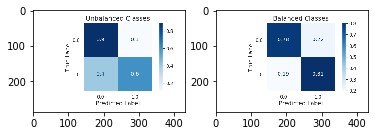

In [45]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(img1)
f.add_subplot(1,2, 2)
plt.imshow(img2)
plt.show(block=True)